In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set( stopwords.words('english'))
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import string
import vaderSentiment
from sklearn.metrics.pairwise import cosine_similarity as cs
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import nltk
from nltk.stem import WordNetLemmatizer

# Load the English language model
nlp = spacy.load("en_core_web_md")

In [2]:
#Reading the Austin restaurant review file

Austin_reviews = pd.read_csv('Dataset_1_Full.csv')
Austin_reviews = Austin_reviews[['Restaurant', 'Comments']]
Austin_reviews

,Restaurant,Comments
0,1618 Asian Fusion,Christian was fabulous. We would highly recomm...
1,1618 Asian Fusion,As soon as we walked in it was very very warm ...
2,1618 Asian Fusion,Visited from Hawaii and was looking for a plac...
3,1618 Asian Fusion,1618 Asian fusion had great service! Shout out...
4,1618 Asian Fusion,Huge menu. Egg rolls for appetizer and Shrimp...
...,...,...
102277,Torchy’s Tacos,I was debating whether to give this restauran...
102278,Torchy’s Tacos,While visiting back home my mom noticed my Tor...
102279,Torchy’s Tacos,Guacamole and chips are delicious! The tortill...
102280,Torchy’s Tacos,Whitest coldest tortilla ever seen at a restau...


In [5]:
# Creating a function to remove stopwords and punctuations

def clean_review(text):
    # Removing punctuations
    text = text.translate(str.maketrans('', '', string.punctuation)).lower().replace('\n', ' ')
    # Removing stopwords
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    
    # Lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    lemmatized_text = ' '.join(lemmatized_words)
    
    return lemmatized_text

In [6]:
Austin_reviews['cleaned_review'] = Austin_reviews['Comments'].map(clean_review)
Austin_reviews['cleaned_review'][0]

'christian fabulous would highly recommend made honeymoon experience everything menu elevated reasonably priced ambiance everything cant wait come back'

In [7]:
# Group by 'Restaurant' and aggregate 'cleaned_review' as combined text
Restaurant_Level_Agg_Comments = Austin_reviews.groupby('Restaurant')['cleaned_review'].apply(lambda x: ' '.join(x)).reset_index()

# Rename the columns
Restaurant_Level_Agg_Comments.columns = ['Restaurant', 'Combined_Reviews']

Restaurant_Level_Agg_Comments['Num_Reviews'] = Austin_reviews.groupby('Restaurant')['cleaned_review'].count().reset_index()['cleaned_review']

Restaurant_Level_Agg_Comments

,Restaurant,Combined_Reviews,Num_Reviews
0,1618 Asian Fusion,christian fabulous would highly recommend made...,534
1,5280 Burger and Taphouse,sat maeve amazing food awesome got guac burger...,192
2,888 Pan Asian Restaurant,moved oltorf last year place quickly became nu...,517
3,ALC Steaks,buffalo lamb chop ribeye truffle bacon mac ord...,520
4,ATX Cocina,staple every time im atx tuna tostada hamachi ...,505
...,...,...,...
218,Wink,service fantastic big fan wine option food goo...,515
219,Workhorse Bar,im overdue reviewbecause frankly ive selfish w...,357
220,Wu Chow,service amazing food family style group shared...,512
221,Yard House,great night dinner friday night arrived around...,525


In [40]:
Restaurant_Level_Agg_Comments.set_index('Restaurant', inplace=True)

In [45]:
Restaurant_Level_Agg_Comments

,Combined_Reviews,Num_Reviews,Noun_List,top_100_Nouns,Lift
Restaurant,,,,,
1618 Asian Fusion,christian fabulous would highly recommend made...,534,"{'honeymoon': 1, 'wait': 52, 'everything': 108...","{'food': 305, 'service': 227, 'place': 175, 't...","{'xiao': 106.4107365792759, 'pho': 62.65305050..."
5280 Burger and Taphouse,sat maeve amazing food awesome got guac burger...,192,"{'section': 1, 'fry': 63, 'smiling': 1, 'sit':...","{'place': 88, 'food': 72, 'fry': 63, 'service'...","{'sport': 15.610805860805861, 'ketchup': 14.74..."
888 Pan Asian Restaurant,moved oltorf last year place quickly became nu...,517,"{'service': 182, 'oltorf': 2, 'year': 38, 'num...","{'food': 319, 'place': 224, 'service': 182, 't...","{'pho': 88.74954355646342, 'clay': 83.53139909..."
ALC Steaks,buffalo lamb chop ribeye truffle bacon mac ord...,520,"{'content': 1, 'truffle': 10, 'portion': 26, '...","{'steak': 353, 'service': 219, 'food': 213, 'p...","{'cattle': 117.26116863905325, 'land': 61.5305..."
ATX Cocina,staple every time im atx tuna tostada hamachi ...,505,"{'daysmonthsever': 1, 'tuna': 18, 'tostada': 2...","{'food': 337, 'service': 193, 'place': 172, 'r...","{'sopes': 106.33277227722772, 'fundido': 48.28..."
...,...,...,...,...,...
Wink,service fantastic big fan wine option food goo...,515,"{'service': 243, 'option': 34, 'food': 335, 'p...","{'food': 335, 'menu': 247, 'service': 243, 'wi...","{'gras': 29.703510520171967, 'foie': 28.581650..."
Workhorse Bar,im overdue reviewbecause frankly ive selfish w...,357,"{'goto': 7, 'im': 33, 'realness': 1, 'song': 4...","{'beer': 209, 'food': 173, 'place': 172, 'sele...","{'jukebox': 252.7978250123579, 'bastrop': 177...."
Wu Chow,service amazing food family style group shared...,512,"{'group': 47, 'service': 197, 'family': 37, 'h...","{'food': 333, 'service': 197, 'place': 183, 's...","{'prawn': 48.75327845982143, 'sum': 45.8408344..."


In [11]:
import nltk
from nltk import pos_tag
from collections import Counter

# Function to generate list of top 100 nouns for each restaurant

def noun_list_comment(text):
    word_pos_1 = pos_tag(text.split())
    list_of_unique_nouns = list(set([word for word, pos in word_pos_1 if (pos.startswith('N'))]))
    return list_of_unique_nouns

In [20]:
def noun_list_restaurant(Restaurant):
    Filtered_comments = Austin_reviews[Austin_reviews['Restaurant'] == Restaurant]['cleaned_review']
    list_of_all_nouns = Filtered_comments.map(noun_list_comment)
    Combined_list_of_nouns = []
    for list in list_of_all_nouns:
        Combined_list_of_nouns = Combined_list_of_nouns+list
    Combined_list_of_nouns = [x for x in Combined_list_of_nouns if x not in Restaurant.lower().split()]
    Noun_Counts = Counter(Combined_list_of_nouns)
    Noun_Counts_Dict = dict(Noun_Counts)
    return Noun_Counts_Dict

In [13]:
def top_100_nouns(all_nouns):
    Sorted_Noun_Counts = sorted(all_nouns.items(), key=lambda x: x[1], reverse=True)
    top_100_Nouns = dict(Sorted_Noun_Counts[:100])
    return top_100_Nouns

In [21]:
#Generating noun list for all restaurants

Restaurant_Level_Agg_Comments['Noun_List'] = Restaurant_Level_Agg_Comments.index.map(noun_list_restaurant)

In [22]:
#Generating top 100 noun list for all restaurants

Restaurant_Level_Agg_Comments['top_100_Nouns'] = Restaurant_Level_Agg_Comments['Noun_List'].map(top_100_nouns)

In [23]:
Restaurant_Level_Agg_Comments

,Restaurant,Combined_Reviews,Num_Reviews,Noun_List,top_100_Nouns
0,1618 Asian Fusion,christian fabulous would highly recommend made...,534,"{'honeymoon': 1, 'wait': 52, 'everything': 108...","{'food': 305, 'service': 227, 'place': 175, 't..."
1,5280 Burger and Taphouse,sat maeve amazing food awesome got guac burger...,192,"{'section': 1, 'fry': 63, 'smiling': 1, 'sit':...","{'place': 88, 'food': 72, 'fry': 63, 'service'..."
2,888 Pan Asian Restaurant,moved oltorf last year place quickly became nu...,517,"{'service': 182, 'oltorf': 2, 'year': 38, 'num...","{'food': 319, 'place': 224, 'service': 182, 't..."
3,ALC Steaks,buffalo lamb chop ribeye truffle bacon mac ord...,520,"{'content': 1, 'truffle': 10, 'portion': 26, '...","{'steak': 353, 'service': 219, 'food': 213, 'p..."
4,ATX Cocina,staple every time im atx tuna tostada hamachi ...,505,"{'daysmonthsever': 1, 'tuna': 18, 'tostada': 2...","{'food': 337, 'service': 193, 'place': 172, 'r..."
...,...,...,...,...,...
218,Wink,service fantastic big fan wine option food goo...,515,"{'service': 243, 'option': 34, 'food': 335, 'p...","{'food': 335, 'menu': 247, 'service': 243, 'wi..."
219,Workhorse Bar,im overdue reviewbecause frankly ive selfish w...,357,"{'goto': 7, 'im': 33, 'realness': 1, 'song': 4...","{'beer': 209, 'food': 173, 'place': 172, 'sele..."
220,Wu Chow,service amazing food family style group shared...,512,"{'group': 47, 'service': 197, 'family': 37, 'h...","{'food': 333, 'service': 197, 'place': 183, 's..."
221,Yard House,great night dinner friday night arrived around...,525,"{'dinner': 53, 'wait': 47, 'watch': 21, 'staff...","{'food': 327, 'service': 211, 'place': 183, 't..."


In [24]:
#Creating a function to calculate lift

def calculate_lift(word, freq_dict, review_count):
    num_a = sum(Nouns.get(word, 0) for Nouns in Restaurant_Level_Agg_Comments['Noun_List'])
    num_a_b = freq_dict[word]
    num_b = review_count
    n = sum(Restaurant_Level_Agg_Comments['Num_Reviews'])
    return float(n)*num_a_b/(num_a*num_b)

In [36]:
#Function to calculate lift for entire list

def all_lifts(row):
    lift_dict = {}
    for word in row['top_100_Nouns'].keys():
        lift_dict[word] = calculate_lift(word, row['top_100_Nouns'], row['Num_Reviews'])
        
    # Sort the dictionary items by values in descending order 
    sorted_lift = sorted(lift_dict.items(), key=lambda x: x[1], reverse=True)
    
    # Take the top 50 values (or all if there are fewer than 50)
    top_50_lift = dict(sorted_lift[:50])
    
    return top_50_lift

In [26]:
#Testing the function

all_lifts(Restaurant_Level_Agg_Comments.loc[3])

{'cattle': 117.26116863905325,
 'land': 61.53059171597633,
 'steakhouse': 49.4457182320442,
 'sampler': 19.822093023255814,
 'ribeye': 18.561468039003252,
 'steak': 15.310637774573827,
 'filet': 12.867972681524083,
 'strip': 10.784294489777208,
 'medium': 10.592463034347851,
 'spinach': 9.737433358720487,
 'chop': 7.974168399168399,
 'carrot': 7.770164090988019,
 'cut': 7.655061396387254,
 'eye': 5.5756390066626285,
 'lamb': 5.091358598261101,
 'mushroom': 3.549534466413868,
 'potato': 3.385133240923887,
 'perfection': 3.3416996406142228,
 'mac': 3.057453168593065,
 'texas': 3.0126778904287974,
 'wine': 2.9855221934655276,
 'house': 2.970768619298031,
 'waiter': 2.9079588464203847,
 'birthday': 2.879885122198446,
 'wife': 2.7525558594204584}

In [37]:
Restaurant_Level_Agg_Comments['Lift'] = Restaurant_Level_Agg_Comments.apply(all_lifts, axis=1)

In [38]:
Restaurant_Level_Agg_Comments

,Restaurant,Combined_Reviews,Num_Reviews,Noun_List,top_100_Nouns,Lift
0,1618 Asian Fusion,christian fabulous would highly recommend made...,534,"{'honeymoon': 1, 'wait': 52, 'everything': 108...","{'food': 305, 'service': 227, 'place': 175, 't...","{'xiao': 106.4107365792759, 'pho': 62.65305050..."
1,5280 Burger and Taphouse,sat maeve amazing food awesome got guac burger...,192,"{'section': 1, 'fry': 63, 'smiling': 1, 'sit':...","{'place': 88, 'food': 72, 'fry': 63, 'service'...","{'sport': 15.610805860805861, 'ketchup': 14.74..."
2,888 Pan Asian Restaurant,moved oltorf last year place quickly became nu...,517,"{'service': 182, 'oltorf': 2, 'year': 38, 'num...","{'food': 319, 'place': 224, 'service': 182, 't...","{'pho': 88.74954355646342, 'clay': 83.53139909..."
3,ALC Steaks,buffalo lamb chop ribeye truffle bacon mac ord...,520,"{'content': 1, 'truffle': 10, 'portion': 26, '...","{'steak': 353, 'service': 219, 'food': 213, 'p...","{'cattle': 117.26116863905325, 'land': 61.5305..."
4,ATX Cocina,staple every time im atx tuna tostada hamachi ...,505,"{'daysmonthsever': 1, 'tuna': 18, 'tostada': 2...","{'food': 337, 'service': 193, 'place': 172, 'r...","{'sopes': 106.33277227722772, 'fundido': 48.28..."
...,...,...,...,...,...,...
218,Wink,service fantastic big fan wine option food goo...,515,"{'service': 243, 'option': 34, 'food': 335, 'p...","{'food': 335, 'menu': 247, 'service': 243, 'wi...","{'gras': 29.703510520171967, 'foie': 28.581650..."
219,Workhorse Bar,im overdue reviewbecause frankly ive selfish w...,357,"{'goto': 7, 'im': 33, 'realness': 1, 'song': 4...","{'beer': 209, 'food': 173, 'place': 172, 'sele...","{'jukebox': 252.7978250123579, 'bastrop': 177...."
220,Wu Chow,service amazing food family style group shared...,512,"{'group': 47, 'service': 197, 'family': 37, 'h...","{'food': 333, 'service': 197, 'place': 183, 's...","{'prawn': 48.75327845982143, 'sum': 45.8408344..."
221,Yard House,great night dinner friday night arrived around...,525,"{'dinner': 53, 'wait': 47, 'watch': 21, 'staff...","{'food': 327, 'service': 211, 'place': 183, 't...","{'poke': 40.820027210884355, 'domain': 36.4110..."


In [53]:
#Creating a function to calculate lift for a restaurant, word pair

def calculate_lift(word, restaurant):
    num_a = sum(Nouns.get(word, 0) for Nouns in Restaurant_Level_Agg_Comments['Noun_List'])
    if word in Restaurant_Level_Agg_Comments.loc[restaurant, 'Noun_List'].keys():
        num_a_b = Restaurant_Level_Agg_Comments.loc[restaurant, 'Noun_List'][word]
    else:
        num_a_b = 0
    num_b = Restaurant_Level_Agg_Comments.loc[restaurant, 'Num_Reviews']
    n = sum(Restaurant_Level_Agg_Comments['Num_Reviews'])
    if num_a == 0:
        Lift = 0
    else:
        Lift = float(n)*num_a_b/(num_a*num_b)
    return Lift

In [47]:
# Creating a list of top attributes

# Use a set to collect the keys from all dictionaries
all_top_attributes = set()

# Collect the keys from all dictionaries using a list comprehension
[all_top_attributes.update(d.keys()) for d in Restaurant_Level_Agg_Comments['Lift']]

# Convert the result back to a list if needed
all_top_attributes = list(all_top_attributes)

# Print the union of keys
len(all_top_attributes)


1439

In [54]:
# Creating a lift dataframe for all restaurants and all top attributes

lift_df = pd.DataFrame(index=Restaurant_Level_Agg_Comments.index, columns=all_top_attributes)

for row_index in lift_df.index:
    for col_name in lift_df.columns:
        lift_df.at[row_index, col_name] = calculate_lift(col_name, row_index)

In [55]:
lift_df

,cheesesteak,con,polenta,student,lemonade,poke,torchys,royale,pesto,samir,...,skip,crowd,ipa,curry,commodore,chago,scratch,matzo,zha,rotisserie
Restaurant,,,,,,,,,,,,,,,,,,,,,
1618 Asian Fusion,0.0,0.256755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.469459,0.276791,0.0,12.883811,0.0,0.0,0.88267,0.0,0.0,0.0
5280 Burger and Taphouse,0.0,0.0,0.0,0.0,2.676979,0.0,0.0,0.0,0.0,0.0,...,1.305683,1.53965,0.0,0.0,0.0,0.0,12.274626,0.0,0.0,0.0
888 Pan Asian Restaurant,0.0,1.060791,0.0,1.373872,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.14357,0.0,13.307457,0.0,0.0,0.0,0.0,0.0,0.0
ALC Steaks,0.0,0.791003,0.0,0.0,0.988423,0.936648,0.0,0.0,0.0,0.0,...,3.374689,1.136972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATX Cocina,0.0,0.814498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992836,1.170743,1.077333,0.0,0.0,0.0,0.933358,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wink,0.0,0.798683,5.254122,0.689604,0.0,0.945742,0.0,6.620194,0.384895,0.0,...,0.973558,1.148011,0.0,0.178122,0.0,0.0,0.0,0.0,0.0,0.0
Workhorse Bar,0.0,1.536216,0.0,0.0,1.43972,0.0,0.0,0.0,0.0,0.0,...,0.0,5.382304,4.571876,0.0,0.0,0.0,3.960888,0.0,0.0,0.0
Wu Chow,0.0,1.606725,0.0,0.0,0.0,0.951283,0.0,0.0,0.0,0.0,...,2.937787,0.288684,0.0,0.0,0.0,0.0,0.920597,0.0,28.538504,0.0


In [65]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download NLTK's VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vgupt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [70]:
#Calculating sentiment scores of all comments

Austin_reviews['Sentiment'] = Austin_reviews['cleaned_review']

sia = SentimentIntensityAnalyzer()

for i in range(len(Austin_reviews)):
    
    # Perform sentiment analysis using VADER
    sentiment = sia.polarity_scores(Austin_reviews['cleaned_review'][i])
    
    Austin_reviews['Sentiment'][i] = sentiment['compound']

In [73]:
Austin_reviews

,Restaurant,Comments,cleaned_review,Sentiment
0,1618 Asian Fusion,Christian was fabulous. We would highly recomm...,christian fabulous would highly recommend made...,0.7346
1,1618 Asian Fusion,As soon as we walked in it was very very warm ...,soon walked warm figured super close door walk...,0.9488
2,1618 Asian Fusion,Visited from Hawaii and was looking for a plac...,visited hawaii looking place good food music 1...,0.9794
3,1618 Asian Fusion,1618 Asian fusion had great service! Shout out...,1618 asian fusion great service shout graham a...,0.9879
4,1618 Asian Fusion,Huge menu. Egg rolls for appetizer and Shrimp...,huge menu egg roll appetizer shrimp panang cur...,0.9468
...,...,...,...,...
102277,Torchy’s Tacos,I was debating whether to give this restauran...,debating whether give restaurant 3 4 decided 4...,0.9691
102278,Torchy’s Tacos,While visiting back home my mom noticed my Tor...,visiting back home mom noticed torchys punchca...,0.9729
102279,Torchy’s Tacos,Guacamole and chips are delicious! The tortill...,guacamole chip delicious tortilla chip right a...,0.9413
102280,Torchy’s Tacos,Whitest coldest tortilla ever seen at a restau...,whitest coldest tortilla ever seen restaurant ...,0.4588


In [87]:
def res_word_sentiment(res, word):
    res_reviews = Austin_reviews[Austin_reviews['Restaurant']== res][['cleaned_review', 'Sentiment']].reset_index()
    if lift_df.loc[res, word] == 0:
        senti = 0
    else:
        senti_list = res_reviews[res_reviews['cleaned_review'].str.contains(word, case=False)]['Sentiment']
        senti = sum(senti_list)/len(senti_list)
    return senti

In [88]:
# Creating a sentiment dataframe for all restaurants and all top attributes

Sentiment_df = pd.DataFrame(index=Restaurant_Level_Agg_Comments.index, columns=all_top_attributes)

for row_index in Sentiment_df.index:
    print(row_index)
    for col_name in Sentiment_df.columns:

        Sentiment_df.at[row_index, col_name] = res_word_sentiment(row_index, col_name)

1618 Asian Fusion
5280 Burger and Taphouse
888 Pan Asian Restaurant
ALC Steaks
ATX Cocina
Aba - Austin
Abo Youssef Mediterraneann Halal
Acre 41
Anthem
Apt 115
Arlo Grey by Kristen Kish
Arturo’s Underground Cafe
Aviary Wine & Kitchen
BD Riley’s Irish Pub at Mueller
Balkan Cafe & Grill
Bangers Sausage House & Beer Garden
Bar Peached
Barley Swine
Bartlett’s
Better Half Coffee & Cocktails
Bikkle Jamaican Restaurant
Bird Bird Biscuit
Black’s Barbecue Austin
Bouldin Creek Cafe
Budare’s Venezuelan Food
Buenos Aires Café - Este
Cabo Bob’s Burritos
Canje
Caroline
Carpenters Hall
Casa Colombia
Casa do Brasil
Ceviche7
Chago’s Caribbean Cuisine - Temp. CLOSED
Citizen Eatery
Clark’s Oyster Bar
Clay Pit
Colleen’s Kitchen
Comedor
Cooper’s Old Time Pit Bar-B-Que
Corinne Austin
Culinary Dropout
DEE DEE
Dai Due
De Nada Cantina
DeSano Pizzeria Napoletana
Dean’s Italian Steakhouse - Austin
Devil May Care
DipDipDip Tatsu-Ya
District Kitchen - Anderson Lane
Doc B’s Restaurant + Bar
Drink Well
Drop Kick
Eber

In [89]:
Sentiment_df

,cheesesteak,con,polenta,student,lemonade,poke,torchys,royale,pesto,samir,...,skip,crowd,ipa,curry,commodore,chago,scratch,matzo,zha,rotisserie
Restaurant,,,,,,,,,,,,,,,,,,,,,
1618 Asian Fusion,0,0.932609,0,0,0,0,0,0,0,0,...,0.9399,0.8818,0,0.915185,0,0,0.6893,0,0,0
5280 Burger and Taphouse,0,0,0,0,0.9883,0,0,0,0,0,...,0.96495,0.9791,0,0,0,0,0.747725,0,0,0
888 Pan Asian Restaurant,0,0.655138,0,0.98445,0,0,0,0,0,0,...,0,0.774805,0,0.796091,0,0,0,0,0,0
ALC Steaks,0,0.868886,0,0,0.6417,0.986067,0,0,0,0,...,0.811323,0.97925,0,0,0,0,0,0,0,0
ATX Cocina,0,0.828603,0,0,0,0,0,0,0,0,...,0.977033,0.94534,0.9958,0,0,0,0.96735,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wink,0,0.891364,0.83732,0.9726,0,0.96432,0,0.9963,0.98395,0,...,0.830018,0.944755,0,0.98765,0,0,0,0,0,0
Workhorse Bar,0,0.792176,0,0,0.9558,0,0,0,0,0,...,0,0.909975,0.9549,0,0,0,0.435033,0,0,0
Wu Chow,0,0.876722,0,0,0,0.939675,0,0,0,0,...,0.742356,0.8855,0,0,0,0,0.9776,0,0.94004,0


In [90]:
# Calculating final evaluation score

Final_Vector_df = pd.DataFrame(index=Restaurant_Level_Agg_Comments.index, columns=all_top_attributes)

for row_index in Final_Vector_df.index:
    for col_name in Final_Vector_df.columns:
        Final_Vector_df.at[row_index, col_name] = lift_df.at[row_index, col_name]*Sentiment_df.at[row_index, col_name]

In [91]:
Final_Vector_df

,cheesesteak,con,polenta,student,lemonade,poke,torchys,royale,pesto,samir,...,skip,crowd,ipa,curry,commodore,chago,scratch,matzo,zha,rotisserie
Restaurant,,,,,,,,,,,,,,,,,,,,,
1618 Asian Fusion,0.0,0.239452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.441245,0.244074,0.0,11.791075,0.0,0.0,0.608424,0.0,0.0,0.0
5280 Burger and Taphouse,0.0,0.0,0.0,0.0,2.645658,0.0,0.0,0.0,0.0,0.0,...,1.259919,1.507471,0.0,0.0,0.0,0.0,9.178044,0.0,0.0,0.0
888 Pan Asian Restaurant,0.0,0.694964,0.0,1.352508,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.886043,0.0,10.593943,0.0,0.0,0.0,0.0,0.0,0.0
ALC Steaks,0.0,0.687292,0.0,0.0,0.634271,0.923598,0.0,0.0,0.0,0.0,...,2.737963,1.11338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATX Cocina,0.0,0.674896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.970034,1.106751,1.072808,0.0,0.0,0.0,0.902884,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wink,0.0,0.711917,4.399382,0.670708,0.0,0.911998,0.0,6.595699,0.378717,0.0,...,0.808071,1.084589,0.0,0.175922,0.0,0.0,0.0,0.0,0.0,0.0
Workhorse Bar,0.0,1.216953,0.0,0.0,1.376084,0.0,0.0,0.0,0.0,0.0,...,0.0,4.897762,4.365684,0.0,0.0,0.0,1.723118,0.0,0.0,0.0
Wu Chow,0.0,1.408651,0.0,0.0,0.0,0.893897,0.0,0.0,0.0,0.0,...,2.180883,0.25563,0.0,0.0,0.0,0.0,0.899976,0.0,26.827336,0.0


In [122]:
Final_Vector_df.to_csv('Final_Vector_df.CSV')

In [96]:
from sklearn.metrics.pairwise import cosine_similarity as cs

# function to calculate cosine similarity for a pair of vectors

def cosine_sim(rest1, rest2):
    df = Final_Vector_df.loc[[rest1,rest2]]
    similarity = cs(df, df)[0,1]
    return similarity

In [97]:
cosine_sim(R'1618 Asian Fusion', '5280 Burger and Taphouse')

0.07015975391150288

In [100]:
def top_3_match(Restaurant):
    sim_dict = {}
    for rest in Restaurant_Level_Agg_Comments.index[Restaurant_Level_Agg_Comments.index!=Restaurant]:
        similarity = cosine_sim(Restaurant, rest)
        sim_dict[rest] = similarity
        sorted_sim_dict = dict(sorted(sim_dict.items(), key=lambda item: item[1], reverse=True))
        # Number of elements to pick (e.g., 3)
        n = 3

        # Using a loop to pick the first n elements
        first_n_elements = {}
        for key, value in sorted_sim_dict.items():
            if len(first_n_elements) < n:
                first_n_elements[key] = value
            else:
                break
    return first_n_elements

In [120]:
top_3_match('1618 Asian Fusion')

{'888 Pan Asian Restaurant': 0.4701292819367321,
 'Lin Asian Bar And Dim Sum': 0.28768827816978904,
 'Wu Chow': 0.22779473635635566}

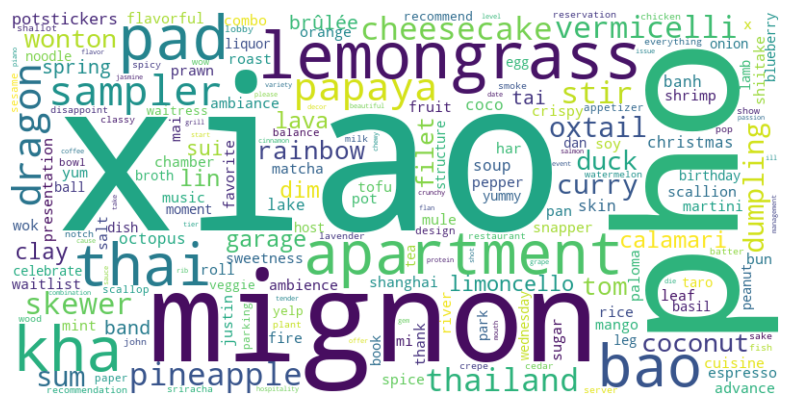

In [115]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a DataFrame with word frequencies (replace with your data)
word_freq_df = Final_Vector_df.loc[['1618 Asian Fusion']]

# Extract the frequencies and words from the DataFrame
frequencies = word_freq_df.iloc[0].tolist()
words = word_freq_df.columns.tolist()

# Create a dictionary where words are keys and frequencies are values
word_frequencies = dict(zip(words, frequencies))

# Create a WordCloud object with word frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

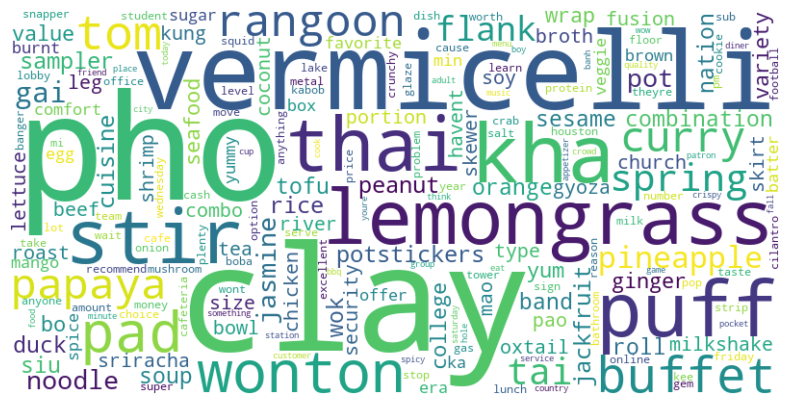

In [116]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a DataFrame with word frequencies (replace with your data)
word_freq_df = Final_Vector_df.loc[['888 Pan Asian Restaurant']]

# Extract the frequencies and words from the DataFrame
frequencies = word_freq_df.iloc[0].tolist()
words = word_freq_df.columns.tolist()

# Create a dictionary where words are keys and frequencies are values
word_frequencies = dict(zip(words, frequencies))

# Create a WordCloud object with word frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [117]:
Restaurant_Level_Agg_Comments.to_csv('Restaurant_Level_Agg_Comments.csv')

In [121]:
Austin_reviews.to_csv('Austin_reviews_Clean.csv')